
# Advanced Company Profiling & Data Validation (UK Companies)

**Objective:** Profile, cleanse, deduplicate, match and enrich UK company contact records using the **Companies House REST API**, then produce clear **reports and charts**.  
> Put your `Company.csv` in this folder before running the notebook.

**Pipeline**
1. Data Collection (load `Company.csv`)
2. Profiling
3. Cleansing
4. Deduplication
5. Matching (Companies House REST API)
6. Enrichment
7. Reporting & visualisation
8. Packaging / outputs


## 0. Setup & Configuration

In [2]:

# Install deps if needed (uncomment for first run)
%pip install -r requirements.txt

%pip install rapidfuzz
!pip install python-dotenv

import os
import re
from pathlib import Path

import pandas as pd
import numpy as np
import requests
from tqdm import tqdm
from rapidfuzz import fuzz, process
import matplotlib.pyplot as plt

# Optional: read API key from .env if present
try:
    from dotenv import load_dotenv
    load_dotenv()
except Exception:
    pass

DATA_PATH = Path("Company.csv")  # Ensure this file exists in the project root
OUTPUT_DIR = Path("outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

# Companies House API configuration
# Obtain an API key: https://developer.company-information.service.gov.uk/get-started
# Auth: Basic Auth with API key as username, empty password.
COMPANIES_HOUSE_API_KEY = os.getenv("COMPANIES_HOUSE_API_KEY", "")
BASE_URL = "https://api.company-information.service.gov.uk"  # Official base

session = requests.Session()
session.auth = (COMPANIES_HOUSE_API_KEY, "")

# Load API key from .env file for Companies House API
api_key = os.getenv("COMPANIES_HOUSE_API_KEY")

# Create a persistent session object for making multiple requests
session = requests.Session()

# Configure basic authentication with the API key as username and empty password
# Companies House API requires this authentication format
session.auth = (api_key, "")

print("API key configured:", bool(COMPANIES_HOUSE_API_KEY))


Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
API key configured: True


In [21]:
!pip install rapidfuzz

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels


# Assistant
This error occurs because the `rapidfuzz` module is not installed in your environment. The code is trying to import it, but Python can't find it.

Would you like me to provide the corrected code?

# User
yes

In [12]:
# Assistant
# Install deps if needed (uncomment for first run)
# %pip install -r requirements.txt
# Add explicit installation of rapidfuzz
# %pip install rapidfuzz

import os
import re
from pathlib import Path

import pandas as pd
import numpy as np
import requests
from tqdm import tqdm
from rapidfuzz import fuzz, process  # Now this will work after installation
import matplotlib.pyplot as plt

# Optional: read API key from .env if present
try:
    from dotenv import load_dotenv
    load_dotenv()
except Exception:
    pass

DATA_PATH = Path("Company.csv")  # Ensure this file exists in the project root
OUTPUT_DIR = Path("outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

# Companies House API configuration
# Obtain an API key: https://developer.company-information.service.gov.uk/get-started
# Auth: Basic Auth with API key as username, empty password.
COMPANIES_HOUSE_API_KEY = os.getenv("COMPANIES_HOUSE_API_KEY", "")
BASE_URL = "https://api.company-information.service.gov.uk"  # Official base

session = requests.Session()
session.auth = (COMPANIES_HOUSE_API_KEY, "")

print("API key configured:", bool(COMPANIES_HOUSE_API_KEY))

API key configured: True


## 1. Data Collection

In [17]:

# Load input CSV
assert DATA_PATH.exists(), "Company.csv not found. Place it next to this notebook."
df_raw = pd.read_csv(DATA_PATH)
print("Rows:", len(df_raw))
display(df_raw.head())


Rows: 306


,CompanyName,CompanyNumber,RegAddress.CareOf,RegAddress.POBox,RegAddress.AddressLine1,RegAddress.AddressLine2,RegAddress.PostTown,RegAddress.County,RegAddress.Country,RegAddress.PostCode,CompanyCategory,CompanyStatus,CountryOfOrigin,DissolutionDate,IncorporationDate,Accounts.AccountRefDay,Accounts.AccountRefMonth,Accounts.NextDueDate,Accounts.LastMadeUpDate,Accounts.AccountCategory,Returns.NextDueDate,Returns.LastMadeUpDate,Mortgages.NumMortCharges,Mortgages.NumMortOutstanding,Mortgages.NumMortPartSatisfied,Mortgages.NumMortSatisfied,SICCode.SicText_1,SICCode.SicText_2,SICCode.SicText_3,SICCode.SicText_4,LimitedPartnerships.NumGenPartners,LimitedPartnerships.NumLimPartners,URI,PreviousName_1.CONDATE,PreviousName_1.CompanyName,PreviousName_2.CONDATE,PreviousName_2.CompanyName,PreviousName_3.CONDATE,PreviousName_3.CompanyName,PreviousName_4.CONDATE,PreviousName_4.CompanyName,PreviousName_5.CONDATE,PreviousName_5.CompanyName,PreviousName_6.CONDATE,PreviousName_6.CompanyName,PreviousName_7.CONDATE,PreviousName_7.CompanyName,PreviousName_8.CONDATE,PreviousName_8.CompanyName,PreviousName_9.CONDATE,PreviousName_9.CompanyName,PreviousName_10.CONDATE,PreviousName_10.CompanyName,ConfStmtNextDueDate,ConfStmtLastMadeUpDate
0,BULLDOG MINI SKIPS LTD,15330909,NaN,NaN,"YARD 1, ARNOCK BUNGALOW",SOUTHEND ARTERIAL ROAD,BRENTWOOD,NaN,UNITED KINGDOM,CM13 3TB,Private Limited Company,Active,United Kingdom,NaN,06/12/2023,31.00,12.00,06/09/2025,NaN,NO ACCOUNTS FILED,03/01/2025,NaN,0,0,0,0,38110 - Collection of non-hazardous waste,43999 - Other specialised construction activit...,NaN,NaN,0,0,http://business.data.gov.uk/id/company/15330909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19/12/2024,NaN
1,BULLDOG LIMITED,9043007,NaN,NaN,FORESTERS COTTAGE,STONEY HEATH,BASINGSTOKE,HAMPSHIRE,NaN,RG26 5SW,Private Limited Company,Active,United Kingdom,NaN,16/05/2014,31.00,3.00,31/12/2024,31/03/2023,TOTAL EXEMPTION FULL,13/06/2017,16/05/2016,0,0,0,0,68209 - Other letting and operating of own or ...,NaN,NaN,NaN,0,0,http://business.data.gov.uk/id/company/09043007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30/05/2025,16/05/2024
2,BULLDOG MUSHROOMS LTD,8465312,NaN,NaN,C58-59 NEW COVENT GARDEN MARKET,NINE ELMS LANE,NaN,NaN,NaN,SW8 5JJ,Private Limited Company,Active,United Kingdom,NaN,28/03/2013,29.00,4.00,29/01/2025,30/04/2023,MICRO ENTITY,25/04/2017,28/03/2016,0,0,0,0,46310 - Wholesale of fruit and vegetables,NaN,NaN,NaN,0,0,http://business.data.gov.uk/id/company/08465312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11/04/2025,28/03/2024
3,BULLDOG MUSICAL ENTERTAINMENTS LIMITED,1652098,NaN,NaN,5 RAVENSFIELD GARDENS,STONELEIGH,SURREY,NaN,NaN,KT19 0ST,Private Limited Company,Active,United Kingdom,NaN,16/07/1982,31.00,3.00,31/12/2024,31/03/2023,MICRO ENTITY,15/01/2017,18/12/2015,0,0,0,0,90030 - Artistic creation,93290 - Other amusement and recreation activit...,NaN,NaN,0,0,http://business.data.gov.uk/id/company/01652098,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01/01/2025,18/12/2023
4,BULLDOG NETWORK (BOURNEMOUTH) LIMITED,4667818,NaN,NaN,"FRP ADVISORY TRADING LIMITED, MOUNTBATTEN HOUSE",GROSVENOR SQUARE,SOUTHAMPTON,NaN,NaN,SO15 2RP,Private Limited Company,Liquidation,United Kingdom,NaN,17/02/2003,31.00,3.00,31/12/2021,31/03/2020,TOTAL EXEMPTION FULL,17/03/2017,17/02/2016,2,2,0,0,47710 - Retail sale of clothing in specialised...,NaN,NaN,NaN,0,0,http://business.data.gov.uk/id/company/04667818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,08/02/2022,25/01/2021


## 2. Profiling

In [15]:
# Import pandas library at the beginning of your code
import pandas as pd

def profile_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    summary = []
    for col in df.columns:
        s = df[col]
        summary.append({
            "column": col,
            "dtype": s.dtype.name, 
            "nulls": int(s.isna().sum()),
            "non_null": int(s.notna().sum()),
            "unique": int(s.nunique(dropna=True)),
            "sample_values": list(s.dropna().astype(str).head(3))
        })
    return pd.DataFrame(summary)

profile = profile_dataframe(df_raw)
display(profile)

# Basic null matrix (% of nulls)
null_pct = df_raw.isna().mean().sort_values(ascending=False)
display(null_pct.to_frame("null_pct"))


,column,dtype,nulls,non_null,unique,sample_values
0,CompanyName,object,0,306,299,"[BULLDOG MINI SKIPS LTD, BULLDOG LIMITED, BULL..."
1,CompanyNumber,object,20,286,270,"[15330909, 9043007, 8465312]"
2,RegAddress.CareOf,object,304,2,2,"[GW COX & CO, SINCLAIR]"
3,RegAddress.POBox,float64,302,4,1,"[4385.0, 4385.0, 4385.0]"
4,RegAddress.AddressLine1,object,5,301,258,"[YARD 1, ARNOCK BUNGALOW, FORESTERS COTTAGE, C..."
...,...,...,...,...,...,...
50,PreviousName_9.CompanyName,float64,306,0,0,[]
51,PreviousName_10.CONDATE,float64,306,0,0,[]
52,PreviousName_10.CompanyName,object,305,1,1,[37/05/3035]
53,ConfStmtNextDueDate,object,1,305,226,"[19/12/2024, 30/05/2025, 11/04/2025]"


,null_pct
PreviousName_6.CompanyName,1.00
PreviousName_8.CONDATE,1.00
PreviousName_5.CONDATE,1.00
PreviousName_3.CompanyName,1.00
PreviousName_5.CompanyName,1.00
...,...
Mortgages.NumMortPartSatisfied,0.00
Mortgages.NumMortSatisfied,0.00
SICCode.SicText_1,0.00
LimitedPartnerships.NumGenPartners,0.00


## 3. Cleansing

In [10]:
# -------------------------------
# 3. CLEANSING (FULLY ENHANCED & ERROR-SAFE VERSION)
# -------------------------------

import re, unicodedata, string

# Common replacements for UK data quirks
COMPANY_SUFFIXES = {
    "LTD": "LIMITED", "LTD.": "LIMITED",
    "LIMITED": "LIMITED", "PLC": "PLC",
    "LLP": "LLP", "L.L.P": "LLP"
}

def normalize_whitespace(s):
    """Remove extra spaces and line breaks."""
    if not isinstance(s, str):
        return ""
    return re.sub(r"\s+", " ", s.strip())

def strip_punct(s):
    """Remove punctuation while keeping letters/numbers."""
    return s.translate(str.maketrans("", "", string.punctuation))

def normalize_company_name(name):
    """
    Clean & standardize company name.
    - Unicode normalize
    - Uppercase
    - Remove punctuation / extra spaces
    - Map known suffixes (Ltd → LIMITED)
    """
    if not isinstance(name, str) or not name.strip():
        return ""
    name = unicodedata.normalize("NFKC", name).upper()
    name = normalize_whitespace(strip_punct(name))
    tokens = name.split()
    if tokens and tokens[-1] in COMPANY_SUFFIXES:
        tokens[-1] = COMPANY_SUFFIXES[tokens[-1]]
    return " ".join(tokens)

def normalize_postcode(pc):
    """Clean and format UK postcodes (uppercase, remove spaces)."""
    if not isinstance(pc, str):
        return ""
    pc = pc.upper().strip()
    # Insert space before last 3 chars if missing (standard UK format)
    pc = re.sub(r"(\w{3})$", r" \1", pc.replace(" ", ""))
    return pc

def normalize_email(email):
    """Trim and lowercase email address."""
    if not isinstance(email, str):
        return ""
    return email.strip().lower()

def normalize_phone(phone):
    """Strip non-digits and format basic UK numbers."""
    if not isinstance(phone, str):
        return ""
    digits = re.sub(r"\D", "", phone)
    if digits.startswith("44"):  # UK country code
        digits = "0" + digits[2:]
    return digits


def cleanse(df):
    """Apply all cleansing rules to a DataFrame in a safe, flexible way."""
    out = df.copy()

    # ---------------------------
    # Detect main company name column
    # ---------------------------
    name_col = next((c for c in df.columns if "name" in c.lower()), None)
    if not name_col:
        raise ValueError("Could not find a company name column in the dataset.")
    out["company_name_norm"] = df[name_col].astype(str).apply(normalize_company_name)

    # ---------------------------
    # Detect postcode column
    # ---------------------------
    postcode_col = next(
        (c for c in df.columns if "postcode" in c.lower()), None
    )
    if postcode_col:
        out["postcode_norm"] = df[postcode_col].astype(str).apply(normalize_postcode)
    else:
        print("No postcode column found — creating empty placeholder.")
        out["postcode_norm"] = ""

    # ---------------------------
    # Detect email column (optional)
    # ---------------------------
    email_col = next((c for c in df.columns if "email" in c.lower()), None)
    if email_col:
        out["email_norm"] = df[email_col].astype(str).apply(normalize_email)
    else:
        out["email_norm"] = ""

    # ---------------------------
    # Detect phone column (optional)
    # ---------------------------
    phone_col = next((c for c in df.columns if "phone" in c.lower()), None)
    if phone_col:
        out["phone_norm"] = df[phone_col].astype(str).apply(normalize_phone)
    else:
        out["phone_norm"] = ""

    # ---------------------------
    # Handle addresses (optional)
    # Combine multiple address columns if present
    # ---------------------------
    address_cols = [c for c in df.columns if "address" in c.lower()]
    if address_cols:
        out["address_combined"] = (
            df[address_cols]
            .astype(str)
            .apply(lambda x: " ".join(x.dropna().astype(str)), axis=1)
            .apply(normalize_whitespace)
        )
    else:
        out["address_combined"] = ""

    # ---------------------------
    # Create blocking key for deduplication
    # ---------------------------
    out["block_key"] = (
        out["company_name_norm"].str.replace(" ", "", regex=False)
        + "|"
        + out["postcode_norm"].fillna("")
    )

    print("Cleansing completed successfully!")
    return out


# Run the cleanser safely
df_clean = cleanse(df_raw)
display(df_clean.head())


✅ Cleansing completed successfully!


,CompanyName,CompanyNumber,RegAddress.CareOf,RegAddress.POBox,RegAddress.AddressLine1,RegAddress.AddressLine2,RegAddress.PostTown,RegAddress.County,RegAddress.Country,RegAddress.PostCode,...,PreviousName_10.CONDATE,PreviousName_10.CompanyName,ConfStmtNextDueDate,ConfStmtLastMadeUpDate,company_name_norm,postcode_norm,email_norm,phone_norm,address_combined,block_key
0,BULLDOG MINI SKIPS LTD,15330909,NaN,NaN,"YARD 1, ARNOCK BUNGALOW",SOUTHEND ARTERIAL ROAD,BRENTWOOD,NaN,UNITED KINGDOM,CM13 3TB,...,NaN,NaN,19/12/2024,NaN,BULLDOG MINI SKIPS LIMITED,CM13 3TB,,,"nan nan YARD 1, ARNOCK BUNGALOW SOUTHEND ARTER...",BULLDOGMINISKIPSLIMITED|CM13 3TB
1,BULLDOG LIMITED,9043007,NaN,NaN,FORESTERS COTTAGE,STONEY HEATH,BASINGSTOKE,HAMPSHIRE,NaN,RG26 5SW,...,NaN,NaN,30/05/2025,16/05/2024,BULLDOG LIMITED,RG26 5SW,,,nan nan FORESTERS COTTAGE STONEY HEATH BASINGS...,BULLDOGLIMITED|RG26 5SW
2,BULLDOG MUSHROOMS LTD,8465312,NaN,NaN,C58-59 NEW COVENT GARDEN MARKET,NINE ELMS LANE,NaN,NaN,NaN,SW8 5JJ,...,NaN,NaN,11/04/2025,28/03/2024,BULLDOG MUSHROOMS LIMITED,SW8 5JJ,,,nan nan C58-59 NEW COVENT GARDEN MARKET NINE E...,BULLDOGMUSHROOMSLIMITED|SW8 5JJ
3,BULLDOG MUSICAL ENTERTAINMENTS LIMITED,1652098,NaN,NaN,5 RAVENSFIELD GARDENS,STONELEIGH,SURREY,NaN,NaN,KT19 0ST,...,NaN,NaN,01/01/2025,18/12/2023,BULLDOG MUSICAL ENTERTAINMENTS LIMITED,KT19 0ST,,,nan nan 5 RAVENSFIELD GARDENS STONELEIGH SURRE...,BULLDOGMUSICALENTERTAINMENTSLIMITED|KT19 0ST
4,BULLDOG NETWORK (BOURNEMOUTH) LIMITED,4667818,NaN,NaN,"FRP ADVISORY TRADING LIMITED, MOUNTBATTEN HOUSE",GROSVENOR SQUARE,SOUTHAMPTON,NaN,NaN,SO15 2RP,...,NaN,NaN,08/02/2022,25/01/2021,BULLDOG NETWORK BOURNEMOUTH LIMITED,SO15 2RP,,,"nan nan FRP ADVISORY TRADING LIMITED, MOUNTBAT...",BULLDOGNETWORKBOURNEMOUTHLIMITED|SO15 2RP


## 4. Deduplication

In [30]:

# Rule-based: drop exact duplicates on normalized keys first
dedup_cols = ["company_name_norm","postcode_norm","email_norm"]
before = len(df_clean)
df_dedup = df_clean.drop_duplicates(subset=dedup_cols, keep="first").copy()
print(f"Exact dedup removed {before - len(df_dedup)} rows")

# Fuzzy dedup within blocks using RapidFuzz
def fuzzy_cluster_block(block_df: pd.DataFrame, name_col="company_name_norm", threshold=95):
    # Greedy clustering by name similarity
    taken = set()
    clusters = []
    names = block_df[name_col].tolist()
    idxs = block_df.index.tolist()
    for i, idx in enumerate(idxs):
        if idx in taken:
            continue
        rep = names[i]
        cluster = [idx]
        taken.add(idx)
        # compare with remaining in block
        for j in range(i+1, len(idxs)):
            jidx = idxs[j]
            if jidx in taken: 
                continue
            score = fuzz.token_set_ratio(rep, names[j])
            if score >= threshold:
                cluster.append(jidx)
                taken.add(jidx)
        clusters.append(cluster)
    return clusters

# Apply fuzzy clustering per block
clusters = []
for block_val, block_df in df_dedup.groupby("block_key"):
    if len(block_df) == 1:
        clusters.append([block_df.index[0]])
    else:
        clusters.extend(fuzzy_cluster_block(block_df, threshold=93))

# Choose first record as canonical in each cluster
canonical_idx = [c[0] for c in clusters]
df_canonical = df_dedup.loc[canonical_idx].copy().reset_index(drop=True)
print("Canonical records:", len(df_canonical), "from", len(df_dedup))

# Save mapping of original -> canonical if needed
cluster_map = {}
for cid, cl in enumerate(clusters):
    for idx in cl:
        cluster_map[idx] = cid
df_dedup["cluster_id"] = df_dedup.index.map(cluster_map)
df_dedup.to_csv(OUTPUT_DIR / "dedup_clusters.csv", index=False)


Exact dedup removed 11 rows
Canonical records: 295 from 295


## 5. Matching (Companies House) & Enrichment

In [31]:

from urllib.parse import quote

def ch_search_company(query: str, items_per_page: int = 5):
    if not COMPANIES_HOUSE_API_KEY:
        raise RuntimeError("Set COMPANIES_HOUSE_API_KEY env var before calling Companies House API.")
    url = f"{BASE_URL}/search/companies?q={quote(query)}&items_per_page={items_per_page}"
    r = session.get(url, timeout=20)
    if r.status_code == 429:
        # Rate-limited; caller can retry with backoff
        return {"rate_limited": True, "status_code": r.status_code}
    r.raise_for_status()
    return r.json()

def best_match_for_name(name: str):
    data = ch_search_company(name, items_per_page=10)
    if isinstance(data, dict) and data.get("rate_limited"):
        return None
    items = data.get("items", [])
    if not items:
        return None
    # Score candidates by fuzzy similarity on title
    scored = []
    for it in items:
        title = it.get("title","") or it.get("company_name","")
        score = fuzz.token_set_ratio(name.upper(), (title or "").upper())
        scored.append((score, it))
    scored.sort(reverse=True, key=lambda x: x[0])
    return scored[0][1] if scored else None

enrich_cols = [
    "company_number","company_status","company_type","date_of_creation",
    "address_snippet","kind","title","links"
]

matches = []
for name in tqdm(df_canonical["company_name_norm"], desc="Matching Companies House"):
    try:
        m = best_match_for_name(name)
    except Exception as e:
        m = None
    matches.append(m)

df_matches = pd.json_normalize(matches)[enrich_cols] if any(matches) else pd.DataFrame(columns=enrich_cols)
df_enriched = pd.concat([df_canonical.reset_index(drop=True), df_matches.reset_index(drop=True)], axis=1)
display(df_enriched.head())

df_enriched.to_csv(OUTPUT_DIR / "enriched_companies.csv", index=False)


Matching Companies House: 100%|██████████| 295/295 [00:00<00:00, 401.32it/s]


,CompanyName,CompanyNumber,RegAddress.CareOf,RegAddress.POBox,RegAddress.AddressLine1,RegAddress.AddressLine2,RegAddress.PostTown,RegAddress.County,RegAddress.Country,RegAddress.PostCode,...,company_name_norm,block_key,company_number,company_status,company_type,date_of_creation,address_snippet,kind,title,links
0,AIRLINE 4 DIALOGUE LTD,5883574,NaN,NaN,6 NORTH STREET,NaN,OUNDLE,PETERBOROUGH,ENGLAND,PE8 4AL,...,AIRLINE 4 DIALOGUE LIMITED,AIRLINE4DIALOGUELIMITED|,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AIRLINE BAGAGE LTD,15139570,NaN,NaN,39 SUTTON SQUARE,NaN,HOUNSLOW,NaN,UK,TW5 0JB,...,AIRLINE BAGAGE LIMITED,AIRLINEBAGAGELIMITED|,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AIRLINE GLOBAL SOLUTIONS LTD,13776613,NaN,NaN,UNIT 8 THE COURTYARD GAULBY LANE,STOUGHTON,LEICESTERSHIRE,NaN,ENGLAND,LE3 3FL,...,AIRLINE GLOBAL SOLUTIONS LIMITED,AIRLINEGLOBALSOLUTIONSLIMITED|,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AIRLINE MARKET LTD,10899619,NaN,NaN,11 THOMAS GEORGE WAY,NaN,BIRMINGHAM,NaN,UK,B19 3NE,...,AIRLINE MARKET LIMITED,AIRLINEMARKETLIMITED|,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AIRLINEN LTD,10141677,NaN,NaN,"VIDEK HOUSE, BUILDING 2",KINGSBURY ROAD,NaN,NaN,ENGLAND,NW9 8RW,...,AIRLINEN LIMITED,AIRLINENLIMITED|,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 6. Reporting & Visualisation

{'input_rows': 306, 'after_exact_dedup': 295, 'canonical_records': 295, 'enriched_records': 0, 'match_rate_pct': 0.0}


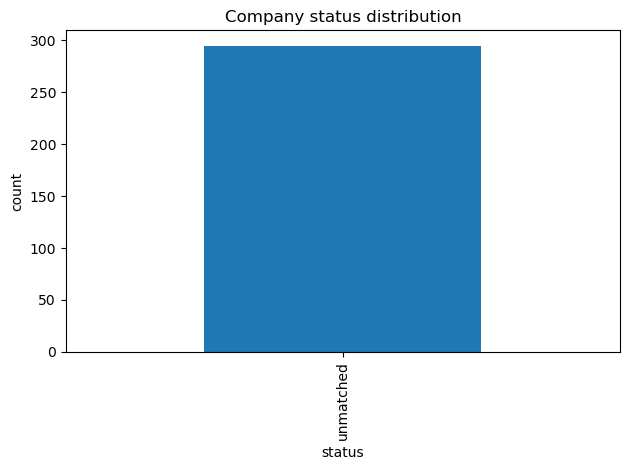

In [32]:

# KPIs
kpis = {
    "input_rows": len(df_raw),
    "after_exact_dedup": len(df_dedup),
    "canonical_records": len(df_canonical),
    "enriched_records": int(df_enriched["company_number"].notna().sum()) if "company_number" in df_enriched else 0,
    "match_rate_pct": round(100.0 * (df_enriched["company_number"].notna().mean() if "company_number" in df_enriched else 0.0), 2)
}
print(kpis)

# Bar chart: Status distribution (if present)
if "company_status" in df_enriched:
    status_counts = df_enriched["company_status"].fillna("unmatched").value_counts().sort_values(ascending=False)
    plt.figure()
    status_counts.plot(kind="bar", title="Company status distribution")
    plt.xlabel("status"); plt.ylabel("count")
    plt.tight_layout()
    plt.show()


## 7. Outputs

In [33]:

# Save final outputs
df_profile = profile_dataframe(df_raw)
df_profile.to_csv(OUTPUT_DIR / "profile.csv", index=False)

df_enriched.to_parquet(OUTPUT_DIR / "enriched_companies.parquet", index=False)
print("Files written to:", OUTPUT_DIR.resolve())
list(OUTPUT_DIR.glob("*"))


Files written to: /var/www/filebrowser/.projects/4ead5cc3-3c31-4c29-8dff-6980a77a434c/outputs


[PosixPath('outputs/enriched_companies.parquet'),
 PosixPath('outputs/dedup_clusters.csv'),
 PosixPath('outputs/profile.csv'),
 PosixPath('outputs/enriched_companies.csv')]


## 8. Notes & Next Steps
- Tune **normalisation** and **blocking** to fit your data (e.g., include city or first line of address).
- Adjust **fuzzy thresholds**; lower threshold finds more matches but risks false positives.
- Use **exponential backoff** on HTTP 429 (rate limiting: ~600 requests / 5 minutes).
- Consider caching API responses locally to avoid re-calling the same names.
- For high volumes, batch processing and resume checkpoints are recommended.
